In [2]:
!nvidia-smi

Fri Mar 24 17:54:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers datasets evaluate wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

## Load Data and Libraries

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from transformers import ViTFeatureExtractor, ViTForImageClassification, AutoFeatureExtractor, ResNetForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, DatasetDict, Dataset, load_dataset

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import wandb
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

In [5]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# !unzip '/content/drive/MyDrive/files/data2.zip' -d '/content/drive/MyDrive/files/data2'

In [8]:
# datasets = load_dataset('imagefolder', data_dir='/content/drive/MyDrive/files/data2')
# datasets = datasets['train'].train_test_split(test_size=.2, seed=42)

# datasets_split = datasets['train'].train_test_split(test_size=.2, seed=42)
# datasets['train'] = datasets_split['train']
# datasets['validation'] = datasets_split['test']

# datasets

In [11]:
datasets = load_dataset('imagefolder', data_dir='/content/drive/MyDrive/lsd/datatest1')

Resolving data files:   0%|          | 0/681 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/149 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/145 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-a4d6db7551cfe671/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 681
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 149
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 145
    })
})

In [13]:
labels = datasets['train'].features['label'].names
labels

['Lumpy Skin', 'Normal Skin']

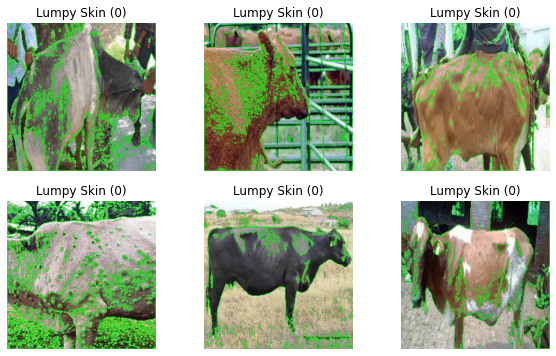

In [14]:
# plot samples
samples = datasets['train'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"{labels[samples[pointer]['label']]} ({samples[pointer]['label']})")
        ax[i,j].axis('off')
        pointer+=1

plt.show()

## ViT - Vision Transformer

In [15]:
model_ckpt = 'google/vit-base-patch16-224-in21k'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [17]:
extractor(samples[0]['image'], return_tensors='pt')
# there are a lot of ones bcs the background of imgs are white, so its normal

{'pixel_values': tensor([[[[-0.5922, -0.1843,  0.3176,  ..., -0.6157, -0.7490, -0.8118],
          [-0.6392, -0.2078,  0.1529,  ..., -0.8745, -0.9686, -0.6941],
          [-0.5137, -0.1686,  0.1294,  ..., -0.5922, -0.8196, -0.5294],
          ...,
          [-0.5137, -0.6471, -0.4353,  ..., -0.6235, -0.3333,  0.0824],
          [-0.6157, -0.9216, -0.8431,  ..., -0.3882, -0.2941, -0.1294],
          [-0.8196, -0.6706, -0.5137,  ...,  0.0824, -0.0824, -0.2392]],

         [[ 0.6392,  0.3725,  0.4745,  ...,  0.5137,  0.6549,  0.8431],
          [ 0.7098,  0.5059,  0.3882,  ..., -0.3176, -0.0824,  0.5922],
          [ 0.6627,  0.4824,  0.3412,  ..., -0.4980, -0.2706,  0.4745],
          ...,
          [ 0.5451, -0.0824, -0.3333,  ...,  0.6627,  0.3882, -0.0196],
          [ 0.6235, -0.0745, -0.1843,  ...,  0.3647,  0.2549,  0.1608],
          [ 0.8510,  0.6078,  0.5137,  ...,  0.0196,  0.1686,  0.4118]],

         [[-0.3569,  0.2078,  0.7961,  ..., -0.6157, -0.7176, -0.8118],
          [-0

In [18]:
def batch_transform(examples):
    # take a list of PIL images and turn into pixel values
    inputs = extractor([x for x in examples['image']], return_tensors='pt')
    # add the labels in
    inputs['label'] = examples['label']
    
    return inputs

In [19]:
transformed_data = datasets.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 681
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 149
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 145
    })
})

In [20]:
# data collator
def collate_fn(examples):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in examples]),
        'labels': torch.tensor([x['label'] for x in examples])
    }

# metrics
metric = load_metric('accuracy')
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1
    }
#     return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-20-857bab8653ad>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


### Zero-shot

In [21]:
model = ViTForImageClassification.from_pretrained(model_ckpt,
                                                 num_labels=len(labels),
                                                 id2label={str(i): c for i, c in enumerate(labels)},
                                                 label2id={c: str(i) for i, c in enumerate(labels)})
model = model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
zero_loader = DataLoader(transformed_data['test'], batch_size=16)
zero_pred = []
for batch in tqdm(zero_loader):
    with torch.no_grad():        
        logits = model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
zero_true = [labels[i] for i in datasets['test']['label']]

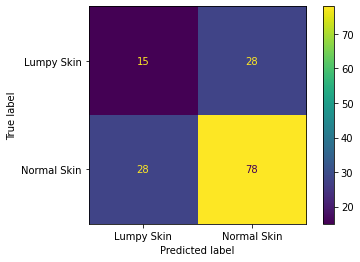

In [24]:
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

In [25]:
print(f'ViT zero-shot Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'ViT zero-shot F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

ViT zero-shot Acc: 0.624
ViT zero-shot F1: 0.624


### Fine Tuning

In [26]:
vit_config = dict(learning_rate = 1e-5,
                  architecture = 'ViT',
                  dataset_id = 'lumpyskin',
                  infra='kaggle')

run = wandb.init(project='lumpyskin',
                notes='project',
                tags=['comparison', 'ViT', 'ResNet'],                 
                config=vit_config,
                name='hf-ViT-base-16-224')

wandb: Currently logged in as: cbtest201 (cbtest). Use `wandb login --relogin` to force relogin


In [27]:
# train props
batch_size = 16
logging_steps = len(transformed_data['train']) // batch_size

In [28]:
training_args = TrainingArguments(output_dir='/content/wandb',
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=10,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=1e-5,
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True)

In [29]:
trainer = Trainer(model=model,
                 args=training_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=extractor)

In [30]:
train_result = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.584200,0.516620,0.710345,0.595773
2,0.402300,0.382044,0.910345,0.906677
3,0.279000,0.304771,0.917241,0.915135
4,0.195400,0.264508,0.889655,0.891140
5,0.152100,0.238182,0.917241,0.917241
6,0.099300,0.240122,0.896552,0.899328
7,0.102400,0.235713,0.903448,0.906257
8,0.085800,0.242669,0.896552,0.899781
9,0.072000,0.230447,0.910345,0.912309
10,0.076300,0.231496,0.917241,0.919264


In [31]:
trainer.evaluate(transformed_data['validation'])

{'eval_loss': 0.23044675588607788,
 'eval_accuracy': 0.9103448275862069,
 'eval_f1': 0.9123094330748427,
 'eval_runtime': 1.9894,
 'eval_samples_per_second': 72.886,
 'eval_steps_per_second': 5.027,
 'epoch': 10.0}

In [32]:
predictions = trainer.predict(transformed_data['test'])
predictions.metrics

{'test_loss': 0.21817365288734436,
 'test_accuracy': 0.9395973154362416,
 'test_f1': 0.9393837958663946,
 'test_runtime': 1.8989,
 'test_samples_per_second': 78.466,
 'test_steps_per_second': 5.266}

In [33]:
run.finish()

eval/accuracy,▁██▇█▇█▇███
eval/f1,▁██▇███████
eval/loss,█▅▃▂▁▁▁▁▁▁▁
eval/runtime,█▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁█▇▇██▇▇██▆
eval/steps_per_second,▁█▇▇██▇▇██▆
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▆▄▃▂▁▁▁▁▁
train/total_flos,▁


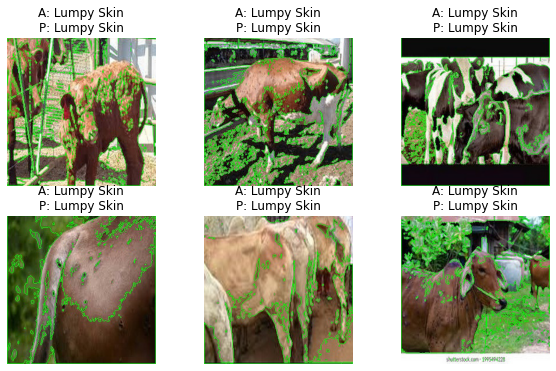

In [34]:
# plot samples
samples = datasets['test'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
        ax[i,j].axis('off')
        pointer+=1

plt.show()

## ResNet152 - Residual Net

### Zero Shot

In [35]:
resnet_ckpt = 'microsoft/resnet-152'

In [36]:
extractor = AutoFeatureExtractor.from_pretrained(resnet_ckpt)
model = ResNetForImageClassification.from_pretrained(resnet_ckpt,
                                                    num_labels=len(labels),
                                                    id2label={str(i): c for i, c in enumerate(labels)},
                                                    label2id={c: str(i) for i, c in enumerate(labels)},
                                                    ignore_mismatched_sizes=True)

model = model.to(device)

/usr/local/lib/python3.9/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-152 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
transformed_data = datasets.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 681
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 149
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 145
    })
})

In [38]:
zero_loader = DataLoader(transformed_data['test'], batch_size=16)
zero_pred = []
for batch in tqdm(zero_loader):
    with torch.no_grad():        
        logits = model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]

  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
zero_true = [labels[i] for i in datasets['test']['label']]

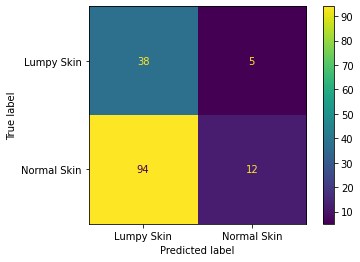

In [40]:
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

In [41]:
print(f'ResNet152 zero-shot Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'ResNet152 zero-shot F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

ResNet152 zero-shot Acc: 0.336
ResNet152 zero-shot F1: 0.264


### Fine Tuning

In [42]:
resnet_config = dict(learning_rate = 1e-5,
                  architecture = 'ViT',
                  dataset_id = 'lsd',
                  infra='kaggle')

run = wandb.init(project='lsd',
                notes='SMLT course project',
                tags=['comparison', 'ViT', 'ResNet'],                 
                config=vit_config,
                name='hf-ResNet-152')

In [43]:
resnet_args = TrainingArguments(output_dir='/content/wandb',
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=10,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=1e-5,
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True,)

In [44]:
resnet_trainer = Trainer(model=model,
                 args=resnet_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=extractor)

In [45]:
resnet_trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.697100,0.675384,0.662069,0.651800
2,0.665300,0.649912,0.724138,0.661949
3,0.642000,0.627968,0.737931,0.645006
4,0.622600,0.611168,0.724138,0.615022
5,0.605600,0.597666,0.717241,0.599141
6,0.582000,0.585905,0.731034,0.630296
7,0.582700,0.575505,0.724138,0.615022
8,0.567200,0.571097,0.724138,0.615022
9,0.558700,0.562737,0.737931,0.645006
10,0.557400,0.567095,0.731034,0.630296


TrainOutput(global_step=430, training_loss=0.6072312199792197, metrics={'train_runtime': 169.859, 'train_samples_per_second': 40.092, 'train_steps_per_second': 2.532, 'total_flos': 3.576430034498765e+17, 'train_loss': 0.6072312199792197, 'epoch': 10.0})

In [46]:
resnet_trainer.evaluate(transformed_data['validation'])

{'eval_loss': 0.5627374053001404,
 'eval_accuracy': 0.7379310344827587,
 'eval_f1': 0.6450059892448454,
 'eval_runtime': 1.3222,
 'eval_samples_per_second': 109.667,
 'eval_steps_per_second': 7.563,
 'epoch': 10.0}

In [47]:
predictions = resnet_trainer.predict(transformed_data['test'])
predictions.metrics

{'test_loss': 0.5736174583435059,
 'test_accuracy': 0.7248322147651006,
 'test_f1': 0.6217742054333826,
 'test_runtime': 1.3292,
 'test_samples_per_second': 112.093,
 'test_steps_per_second': 7.523}

In [48]:
run.finish()

eval/accuracy,▁▇█▇▆▇▇▇█▇█
eval/f1,▇█▆▃▁▄▃▃▆▄▆
eval/loss,█▆▅▄▃▂▂▂▁▁▁
eval/runtime,▂▃▇▇▇▇█▁▂▁▄
eval/samples_per_second,▇▆▁▂▂▂▁█▇█▅
eval/steps_per_second,▇▆▁▂▂▂▁█▇█▅
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▆▅▄▃▂▂▁▁▁
train/total_flos,▁


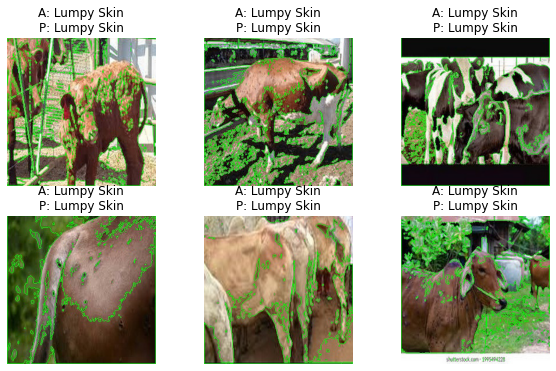

In [49]:
# plot samples
samples = datasets['test'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
        ax[i,j].axis('off')
        pointer+=1

plt.show()

## ResNet50 - Residual Net

### Zero Shot

In [50]:
resnet50_ckpt = 'microsoft/resnet-50'

In [51]:
extractor = AutoFeatureExtractor.from_pretrained(resnet50_ckpt)
model = ResNetForImageClassification.from_pretrained(resnet50_ckpt,
                                                    num_labels=len(labels),
                                                    id2label={str(i): c for i, c in enumerate(labels)},
                                                    label2id={c: str(i) for i, c in enumerate(labels)},
                                                    ignore_mismatched_sizes=True)

model = model.to(device)

/usr/local/lib/python3.9/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
transformed_data = datasets.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 681
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 149
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 145
    })
})

In [53]:
zero_loader = DataLoader(transformed_data['test'], batch_size=16)
zero_pred = []
for batch in tqdm(zero_loader):
    with torch.no_grad():        
        logits = model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]

  0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
zero_true = [labels[i] for i in datasets['test']['label']]

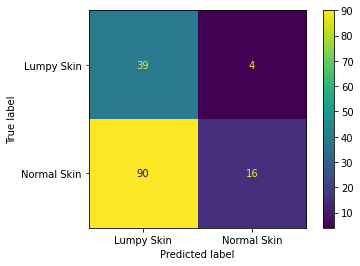

In [55]:
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

In [56]:
print(f'ResNet50 zero-shot Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'ResNet50 zero-shot F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

ResNet50 zero-shot Acc: 0.369
ResNet50 zero-shot F1: 0.312


### Fine Tuning

In [57]:
resnet50_config = dict(learning_rate = 1e-5,
                  architecture = 'ResNet50',
                  dataset_id = 'lsd',
                  infra='kaggle')

run = wandb.init(project='lsd',
                notes='SMLT course project',
                tags=['comparison', 'ViT', 'ResNet'],                 
                config=resnet50_config,
                name='hf-ResNet-50')

In [58]:
resnet50_args = TrainingArguments(output_dir='/content/wandb',
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=10,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=1e-5,
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True,)

In [59]:
resnet50_trainer = Trainer(model=model,
                 args=resnet50_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=extractor)

In [60]:
resnet50_trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.702000,0.689480,0.524138,0.545919
2,0.676200,0.675000,0.682759,0.677617
3,0.655500,0.657466,0.737931,0.697265
4,0.642000,0.636488,0.731034,0.658879
5,0.630800,0.629819,0.737931,0.663525
6,0.613000,0.618263,0.724138,0.615022
7,0.615000,0.620969,0.737931,0.645006
8,0.602700,0.623183,0.724138,0.636542
9,0.596100,0.603963,0.717241,0.599141
10,0.595100,0.606045,0.717241,0.599141


TrainOutput(global_step=430, training_loss=0.6321375336757926, metrics={'train_runtime': 94.2966, 'train_samples_per_second': 72.219, 'train_steps_per_second': 4.56, 'total_flos': 1.446130973435904e+17, 'train_loss': 0.6321375336757926, 'epoch': 10.0})

In [61]:
resnet50_trainer.evaluate(transformed_data['validation'])

{'eval_loss': 0.6039634943008423,
 'eval_accuracy': 0.7172413793103448,
 'eval_f1': 0.5991413931588423,
 'eval_runtime': 1.0031,
 'eval_samples_per_second': 144.556,
 'eval_steps_per_second': 9.969,
 'epoch': 10.0}

In [62]:
predictions = resnet50_trainer.predict(transformed_data['test'])
predictions.metrics

{'test_loss': 0.6048625111579895,
 'test_accuracy': 0.7114093959731543,
 'test_f1': 0.6033241666740354,
 'test_runtime': 1.0637,
 'test_samples_per_second': 140.081,
 'test_steps_per_second': 9.401}

In [63]:
run.finish()

eval/accuracy,▁▆██████▇▇▇
eval/f1,▁▇█▆▆▄▆▅▃▃▃
eval/loss,█▇▅▄▃▂▂▃▁▁▁
eval/runtime,▆▂█▁▁▄▁▇▂▁▃
eval/samples_per_second,▃▇▁██▄▇▂▆▇▅
eval/steps_per_second,▃▇▁██▄▇▂▆▇▅
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▆▅▄▃▂▂▁▁▁
train/total_flos,▁


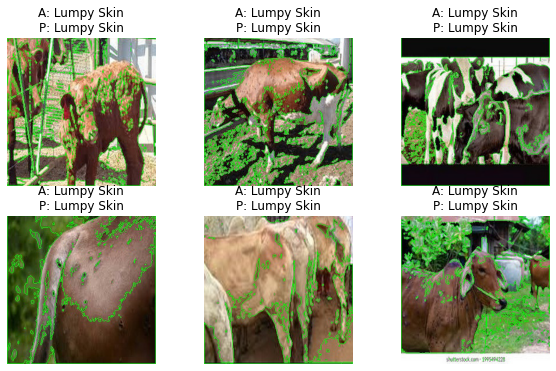

In [64]:
# plot samples
samples = datasets['test'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
        ax[i,j].axis('off')
        pointer+=1

plt.show()